In [29]:
from proxmox.dict import proxmox_nodes
from proxmox.docs import _proxmox_api_docs
from proxmox.base import ProxmoxAPIChain
from langchain.text_splitter import RecursiveJsonSplitter
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.vectorstores.surrealdb import SurrealDBStore
from langchain_huggingface import HuggingFaceEmbeddings
import nest_asyncio
import os
import hvac
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm, trange
import torch
import getpass

In [30]:
# Load environment variables from .env file
load_dotenv()

True

In [31]:
def get_vault_token():
    token = os.getenv('VAULT_TOKEN')
    if not token:
        os.environ['VAULT_TOKEN'] = getpass.getpass(f"Please provide your Vault token:").strip()
    return os.environ['VAULT_TOKEN']

# Function to access the secret from Vault
def access_vault_secret(vault_token, url, secret_path):
    try:
        client = hvac.Client(url=url, token=vault_token)
        response = client.secrets.kv.v2.read_secret_version(path=secret_path, mount_point="kv" , raise_on_deleted_version=True)
        if response:
            secret_data = response['data']['data']
            print(f"Accessed Vault secret at {secret_path}.")
            return secret_data
        else:
            print(f"Failed to access Vault secret at {secret_path}.")
            return None
    except hvac.exceptions.VaultError as e:
        print(f"Request to Vault failed: {e}")
        return None

vault_token = get_vault_token()

# Retrieve Vault URL from environment variables
vault_url = os.getenv('VAULT_URL')

# Paths to secrets in Vault
#proxmox_secret_path = "users/accounts/api-tokens/proxmox/oumaima"
surrealdb_url_path = "users/accounts/surrealdb"
surrealdb_credentials_path = "users/accounts/surrealdb/oumaima"

# Access SurrealDB URL from Vault
surrealdb_url_secret = access_vault_secret(vault_token, vault_url, surrealdb_url_path)
if surrealdb_url_secret:
    os.environ['SURREALDB_URL'] = surrealdb_url_secret.get('url')
else:
    print("Failed to retrieve SurrealDB URL.")

# Access SurrealDB credentials from Vault
surrealdb_credentials_secret = access_vault_secret(vault_token, vault_url, surrealdb_credentials_path)
if surrealdb_credentials_secret:
    os.environ['SURREALDB_USER'] = surrealdb_credentials_secret.get('user')
    os.environ['SURREALDB_PWD'] = surrealdb_credentials_secret.get('password')
else:
    print("Failed to retrieve SurrealDB credentials.")

Accessed Vault secret at users/accounts/surrealdb.
Accessed Vault secret at users/accounts/surrealdb/oumaima.


In [32]:
surrealdb_url = os.getenv('SURREALDB_URL')
surrealdb_user = os.getenv('SURREALDB_USER')
surrealdb_password = os.getenv('SURREALDB_PWD')

In [33]:
splitter = RecursiveJsonSplitter(max_chunk_size=4000)
docs = splitter.create_documents(_proxmox_api_docs)

In [34]:
# Initialize the SentenceTransformerEmbeddings with trust_remote_code=True
ef = HuggingFaceEmbeddings(
    model_name="infgrad/stella_en_400M_v5",
    model_kwargs={
        "trust_remote_code": True,
    }
)

Some weights of the model checkpoint at infgrad/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
nest_asyncio.apply()

# SurrealDB connection parameters
dburl = "ws://localhost:8000/rpc"
ns = "langchain"
db_name = "proxmox_api_docs"
collection = "proxmox_collection"
db_user = surrealdb_user
db_pass = surrealdb_password

# Initialize the SurrealDBStore with documents
db = SurrealDBStore(
    embedding_function=ef,
    dburl=dburl,
    ns=ns,
    db=db_name,
    collection=collection,
    db_user=db_user,
    db_pass=db_pass
)


# this is needed to initialize the underlying async library for SurrealDB
await db.initialize()

# delete collection from the vectorstore collection if it exists 
await db.adelete(collection = collection)

# add documents to the vectorstore
ids = await db.aadd_documents(docs)

retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# Initialize the cross-encoder model
#cross_encoder_model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
cross_encoder_model = HuggingFaceCrossEncoder(model_name="cross-encoder/ms-marco-MiniLM-L-6-v2")
compressor = CrossEncoderReranker(model=cross_encoder_model, top_n=3)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

In [36]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Initialize the llm with the new model
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0)

In [37]:
# Instantiate the ProxmoxAPIChain for each node
def create_agent_executor(base_url, api_token ):
    if not api_token:
        raise ValueError("API token must be provided and cannot be None.")
    
    headers = {"Authorization": api_token}
    return ProxmoxAPIChain.from_llm_and_api_docs(
        llm=llm,  # Replace with actual LLM instance
        retriever=compression_retriever,
        headers=headers,
        verbose=True,
        base_url=base_url,
        pve_token=api_token,
        limit_to_domains=[base_url]
    )


In [38]:
from langchain.schema.messages import HumanMessage

# Agent Node Function
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["output"], name=name)],
        "team_members": state["team_members"],
        "next": state["next"],
    }


In [39]:
from typing import Any, Dict
from langchain_community.llms import Ollama


llm_kwargs: Dict[str, Any] = {
    "model": "phi3",
    "temperature": 0,
    "num_ctx": 4096, 
    "format":"json",
}

llm_sup = Ollama(**llm_kwargs)

In [40]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import JsonOutputParser

def create_team_supervisor(llm, system_prompt, members):
    options = ["FINISH"] + members
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        |llm
        | JsonOutputParser()
    )

In [41]:
from langchain_core.messages import (
    BaseMessage,
)
import operator
from typing import Annotated, List,TypedDict


class ProxmoxTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

In [42]:
for node_name, node_info in proxmox_nodes.items():
    print(node_info)

{'base_url': 'https://ns31418912.ip-54-38-37.eu:8006', 'api_token': 'proxmox_HCM_api_token'}
{'base_url': 'https://ns31212248.ip-51-178-74.eu:8006', 'api_token': 'node5_api_token'}


In [43]:
import functools

agents_and_nodes = {}

for node_name, node_info in proxmox_nodes.items():
    agent_executor = create_agent_executor(base_url=node_info["base_url"], api_token=node_info["api_token"])
    agent_node_partial = functools.partial(agent_node, agent=agent_executor, name=node_name)
    agents_and_nodes[node_name] = {
        "agent": agent_executor,
        "node": agent_node_partial
    }

    

In [44]:
supervisor_agent = create_team_supervisor(
    llm_sup,
    "You are a supervisor tasked with routing a query to one of the"
    " following workers:  ProxmoxHCM, Node5. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. The worker output gonna be returned to the user . When finished,"
    " respond with FINISH.",
    ["ProxmoxHCM", "Node5"],
)

In [45]:
from langgraph.graph import END, StateGraph, START

proxmox_graph = StateGraph(ProxmoxTeamState)
for node_name, node_info in proxmox_nodes.items():
    # Add node to the graph
    proxmox_graph.add_node(node_name, agent_node_partial)
    # Add edge to END node
    proxmox_graph.add_edge(node_name, END)

proxmox_graph.add_node("supervisor", supervisor_agent)

# Define the control flow for the supervisor
proxmox_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {node_name: node_name for node_name in proxmox_nodes.keys()},
)


proxmox_graph.add_edge(START, "supervisor")
chain = proxmox_graph.compile()


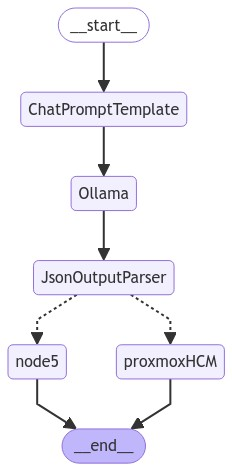

In [46]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [47]:
for s in chain.stream(
    {
        "messages": [
            HumanMessage(
                content="list all containers on node 'Proxmox-Node-HCM"
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

InvalidUpdateError: Must write to at least one of ['messages', 'team_members', 'next']